In [1]:
# Preparing inputs, variables, and data

import numpy as np # scientific computing 
import scipy.io
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigs
from sklearn import linear_model
from sklearn import svm 
from sklearn.naive_bayes import GaussianNB
import pandas as pd # data manipulation 
import brainiak.funcalign.srm
import brainiak.funcalign.rsrm
from brainiak import image, io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline 
import time

# descriptive variables for the dataset 
# the data consists of 1976 total TRs (time repetitions, i.e. when a single image was taken) for 17 participants
# taken in 2 separate (but concatenated) runs. 
# experimenters further identified 50 different scenes within this time period, and labelled whether or not
# participants recalled those scenes during a later recall task 
nScenes = 50
nScenes1 = 27
nTRs1 = 946 
nScenes2 = 23
nTRs2 = 1030
n = 17

# for each participant (of 17), let's get the recall data for each of 50 scenes 
# 3 variables (columns): recalled (1/0), quality (0-5), recall time len (0+)
recall_dfs = []
recall_path = "SherlockData/recall_transcripts/"
for pid in range(1, 18):
    filename = "NN_S" + str(pid) + "_Scene_Matches_edit4matlab.xlsx"
    file = pd.read_excel(recall_path + filename)
    file = file.replace(np.nan, -1, regex=True)
    quality = []
    recalled = []
    duration = []
    for s in range(50):
        if file['quality'][s] == -1: # did not recall
            quality.append(0)
            recalled.append(0)
            duration.append(0)
        else:
            quality.append(file['quality'][s])
            recalled.append(1)
            duration.append(file['end time sec'][s] - file['start time sec'][s])
    recall_dfs.append(np.transpose([recalled, quality, duration]))
    
recall_dfs = np.array(recall_dfs)

# Brain data: 17 participants, 26k WB mask voxels, 1976 TRs (time-of-repetition, i.e. one time point/1.5s in this case)
movie_data = []
for pid in range(1, 18):
    moviedat = np.load("SherlockData/movie_masked/movie_wb_S" + str(pid) + ".npz")['data']
    # stored as TR x voxel, but we want voxel x TR data 
    movie_data.append(np.transpose(moviedat))
    
movie_data = np.array(movie_data)

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
# zscores each of list of 2D arrays, by row
# For each participant, we want to compare how the voxel activations change over time, 
# rather than the absolute voxel activations 
def zscore(data):
    for pid in range(len(data)):
        data[pid] = np.nan_to_num(stats.zscore(data[pid], axis = 1, ddof = 1))
    return np.array(data)

# Downsampling function (features x TRs -> features x SCENES)
# given data matrix of 1 participant (features x TRs)
# returns a features x SCENEs matrix, where 
# corresponding TRs in a scene are averaged 
# if r2 is True, then movie data corresponds to only the second run
movieTRs = np.array(pd.read_csv("movieTRs.csv", index_col = 0))
def scene_voxelavg(dat_tr, startind = 0, endind = nScenes, r2 = False):
    dat_sc = []
    for sceneidx in range(startind, endind):
        offset = 1
        if r2:
            offset = offset + nTRs1
        startTR = movieTRs[sceneidx, 1] - offset
        endTR = movieTRs[sceneidx, 2] - offset
        response_avg = np.reshape(np.mean(dat_tr[:,startTR:endTR + 1], axis = 1), (-1, 1))
        if len(dat_sc) == 0:
            dat_sc = response_avg
        else:
            dat_sc = np.append(dat_sc, response_avg, axis = 1)
    return np.array(dat_sc)

# given a participant index and
# recalltype (0 for nRecall, 1 for time of recall, 2 for quality of recall)
# returns a nTRs-len vector representation for recall from start scene index
# i.e. expands a recall outcome vector from length SCENES to TRs
# note that this is a very imprecise way of identifying recall, as it is possible that 
# participants recalled only parts of the scene and not others
def get_recall_labels(pidx, recalltype, startind = 0, endind = nScenes):
    labels_byTR = []
    startTR = movieTRs[startind, 1] - 1 
    for sceneidx in range(startind, endind):
        endTR = movieTRs[sceneidx, 2] - 1 
        labels_byTR = np.append(labels_byTR, 
            np.repeat(recall_dfs[pidx, sceneidx, recalltype], endTR-startTR+1))
        startTR = endTR + 1
    return labels_byTR

# takes a (pid x features x time) matrix set and concatenates all pids by feature, and transposes it
# such that each row corresponds to a single time observation
def flatdat(dat):
    flat = dat[0]
    for i in range(1, len(dat)):
        flat = np.append(flat, dat[i], axis = 1)
    return np.array(flat.T)

movie_data1 = zscore(movie_data[:, :, :nTRs1])
movie_data2 = zscore(movie_data[:, :, nTRs1:])

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: divide by zero encountered in true_divide
  np.expand_dims(sstd, axis=axis))
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


In [3]:
### 1. In shared space (shared_data: 17 x 50 x 1976, downsampled into 17 x 50 x 50)
#### note: we'll also record results using individual data (i.e. the individual "noise" that is not shared), 
#### as well as null predictions (what would be predicted with scrambled labels) to see how well our model
#### does, comparatively. To learn "individual data", instead of learning X_i = W_i * R , where R is the shared 
#### signal and W_i are the individual subject basis that help map from voxel to feature space, we will use
#### the RSRM (robust shared response model) to learn X_i = W_i * R + S_i for individual S_i signals

In [15]:
# We can test how well we can predict recall using LOOCV, leaving out one participant at a time and training on the rest 
# divide the data into data to fit the SRM, and data to train the classifier 
# to avoid "peeking" problems

# Predicts the variable for one participant, training on the others 
def predictRecallLOO(pid, predict_run = 2):
    # separate participants into training and testing 
    train_pids = [i for i in range(n) if i != pid]
    test_pids = [pid]

    # Learning subject specific bases in shared space using half the movie data  
    if predict_run == 2:
        data_SRM = movie_data1 
        data_classify = movie_data2
        startscene = nScenes1
        endscene = nScenes
    else:
        data_SRM = movie_data2
        data_classify = movie_data1
        startscene = 0
        endscene = nScenes1
    
    srm = brainiak.funcalign.rsrm.RSRM(n_iter = 10, features = 50)
    srm.fit(data_SRM[train_pids])
    
    w_test = [srm.transform_subject(data_SRM[i])[0] for i in test_pids]

    # Get shared and individual data in the other half of the movie
    train_shared, train_ind = srm.transform(data_classify[train_pids])
    
    # shared response matrix (k x TR) in second half = Wi.T(Xi - Si)
    shared = np.matmul(srm.w_[0].T, data_classify[train_pids[0]] - train_ind[0])
    
    test_shared = []
    test_ind = []
    for i in range(len(test_pids)):
        test_ind.append(data_classify[test_pids[i]] - np.matmul(w_test[i], shared))
        test_shared.append(np.matmul(w_test[i].T, data_classify[test_pids[i]] - test_ind[i]))
    test_shared = np.array(test_shared)
    test_ind = np.array(test_ind)
        
    if predict_run == 2:
        train_data_s = [scene_voxelavg(train_shared[i], nScenes1, nScenes, r2 = True) for i in range(len(train_pids))]
        test_data_s = [scene_voxelavg(test_shared[i], startind = nScenes1, endind = nScenes, r2 = True) for i in range(len(test_pids))]
        train_data_ind = [scene_voxelavg(train_ind[i], nScenes1, nScenes, r2 = True) for i in range(len(train_pids))]
        test_data_ind = [scene_voxelavg(test_ind[i], startind = nScenes1, endind = nScenes, r2 = True) for i in range(len(test_pids))]
        ytrain = np.ravel(recall_dfs[train_pids, nScenes1:, 0])
        ytest = np.ravel(recall_dfs[test_pids, nScenes1:, 0])
    else:
        train_data_s = [scene_voxelavg(train_shared[i], 0, nScenes1) for i in range(len(train_pids))]
        test_data_s = [scene_voxelavg(test_shared[i], startind = 0, endind = nScenes1) for i in range(len(test_pids))]
        train_data_ind = [scene_voxelavg(train_ind[i], 0, nScenes1) for i in range(len(train_pids))]
        test_data_ind = [scene_voxelavg(test_ind[i], startind = 0, endind = nScenes1) for i in range(len(test_pids))]                                                                                                            
        ytrain = np.ravel(recall_dfs[train_pids, :nScenes1, 0])
        ytest = np.ravel(recall_dfs[test_pids, :nScenes1, 0])
    
    classifier_s = GaussianNB()                                                                                                  
    classifier_s.fit(flatdat(train_data_s), ytrain)
    preds_s = classifier_s.predict(flatdat(test_data_s))
                                                                                                      
    classifier_ind = GaussianNB()                                                                                                  
    classifier_ind.fit(flatdat(train_data_ind), ytrain)
    preds_ind = classifier_ind.predict(flatdat(test_data_ind))                                                                                                
    
    return preds_s, preds_ind, ytest

def predictRecallLOOCV(recalltype = 0, predict_run = 2):
    sharedscores = []
    indscores = []
    for pid in range(n): # leave one participant out for the cv 
        preds_s, preds_ind, y = predictRecallLOO(pid, predict_run)
        results_s = np.mean(preds_s == y)
        results_ind = np.mean(preds_ind == y)
                                                                                                      
        print(pid, results_s, results_ind)
        sharedscores.append(results_s)
        indscores.append(results_ind)
    return sharedscores, indscores # list of accuracy for each subject

In [16]:
s0, ind0, y0 = predictRecallLOO(0)

In [17]:
np.mean(s0 == y0), np.mean(ind0 == y0)

(0.782608695652174, 0.7391304347826086)

Text(0.5, 1.0, 'Recall predictions for Run2')

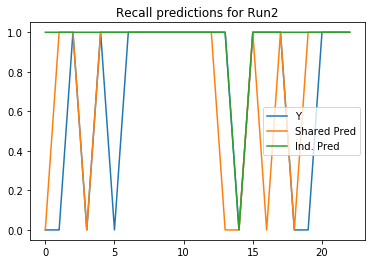

In [22]:
plt.plot(y0)
plt.plot(s0)
plt.plot(ind0)
plt.legend(["Y", "Shared Pred", "Ind. Pred"])
plt.title("Recall predictions for Run2")

In [23]:
results_shared = []
results_ind = []
results = []
for pid in range(n):
    start = time.time()
    spred, indpred, y = predictRecallLOO(pid)
    results.append([spred, indpred, y])
    results_shared.append(np.mean(spred == y))
    results_ind.append(np.mean(indpred == y))
    print("PID %d finished in %f time" % (pid, time.time() - start))

PID 0 finished in 712.608250 time
PID 1 finished in 703.985678 time
PID 2 finished in 892.854236 time
PID 3 finished in 704.230291 time
PID 4 finished in 781.539669 time
PID 5 finished in 971.479416 time
PID 6 finished in 714.842790 time
PID 7 finished in 803.374257 time
PID 8 finished in 926.441160 time
PID 9 finished in 882.284433 time
PID 10 finished in 741.372320 time
PID 11 finished in 701.762052 time
PID 12 finished in 698.815982 time
PID 13 finished in 701.386087 time
PID 14 finished in 700.867101 time
PID 15 finished in 700.240835 time
PID 16 finished in 701.293157 time


In [24]:
results_shared, results_ind, stats.ttest_rel(results_shared, results_ind)

([0.782608695652174,
  0.5217391304347826,
  0.5652173913043478,
  0.5652173913043478,
  0.5652173913043478,
  0.782608695652174,
  0.6521739130434783,
  0.6086956521739131,
  0.6086956521739131,
  0.6521739130434783,
  0.6521739130434783,
  0.6086956521739131,
  0.7391304347826086,
  0.7391304347826086,
  0.6521739130434783,
  0.5217391304347826,
  0.782608695652174],
 [0.7391304347826086,
  0.6086956521739131,
  0.8260869565217391,
  0.6086956521739131,
  0.782608695652174,
  0.7391304347826086,
  0.5652173913043478,
  0.6521739130434783,
  0.6521739130434783,
  0.6086956521739131,
  0.6521739130434783,
  0.5217391304347826,
  0.7391304347826086,
  0.34782608695652173,
  0.7391304347826086,
  0.6956521739130435,
  0.782608695652174],
 Ttest_relResult(statistic=-0.43643578047198467, pvalue=0.6683526387131726))

Text(0.5, 1.0, 'Accuracy of Recall Predictions \n using shared vs. individual signals (p = 0.67)')

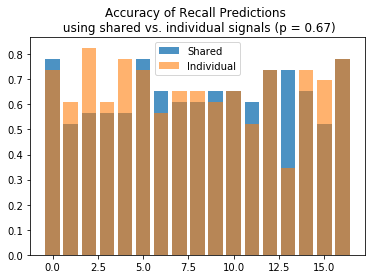

In [32]:
plt.bar(range(n), results_shared, alpha = 0.8)
plt.bar(range(n), results_ind, alpha = 0.6)
plt.legend(["Shared", "Individual"])
plt.title("Accuracy of Recall Predictions \n using shared vs. individual signals (p = 0.67)")